# Plotting Extrapolated Field Lines: MayaVi and/or `yt`?

Want to understand the structure of the output from the `solarbextrapolation` routines. Should be someway to extract the individual field line information without having to mess around with the MayaVi GUI...

In [1]:
#Import needed modules
#general
import astropy.units as u
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
#solarbextrapolation
from solarbextrapolation.map3dclasses import Map3D
from solarbextrapolation.extrapolators import PotentialExtrapolator
from solarbextrapolation.example_data_generator import generate_example_data, dummyDataToMap
#yt
import yt
from yt.visualization.api import Streamlines
from yt.units import Mpc

/Users/willbarnes/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/willbarnes/anaconda/envs/python2/lib/python2.7/site-packages/sunpy/visualization/wcsaxes_compat.py:17: UserWarning: SunPy plotting is improved by installing the WCSAxes module: http://wcsaxes.readthedocs.org/en/latest/index.html
  warnings.warn("SunPy plotting is improved by installing the WCSAxes module: http://wcsaxes.readthedocs.org/en/latest/index.html")


## Generate Simulated Magnetogram
To test this, we'll use the `generate_example_data` module from `solarbextrapolation`. First, define the basic coordinates.

In [56]:
arr_grid_shape = [ 20, 22, 50 ]
xrange = u.Quantity([ -arr_grid_shape[0]/2, arr_grid_shape[0]/2 ] * u.arcsec)
yrange = u.Quantity([ -arr_grid_shape[1]/2, arr_grid_shape[1]/2 ] * u.arcsec)
zrange = u.Quantity([ 0, arr_grid_shape[2] ] * u.arcsec)

This is an $N_y\times N_x\times N_z$ 3D cuboid with units of arcsecs as given by the `astropy.units` module. Next, configure the position, size, and strength of the pole on the lower boundary.

In [72]:
arrA0 = [ u.Quantity([ 35, 35 ] * u.percent), 5.0 * u.percent,  .5 * u.T ]
arrA1 = [ u.Quantity([ 65, 65 ] * u.percent), 5.0 * u.percent, -.5 * u.T ]

This gives a bipolar field rooted in the center of the second and fourth quadrants with a spread of 25% and a strength of 5 Tesla. Now, hand this off to the data generator function to create the `numpy` array.

In [73]:
arr_data = generate_example_data(arr_grid_shape[0:2],xrange,yrange,arrA0,arrA1)

Now, build a `sunpy` map out of the 2D array.

In [74]:
map_boundary = dummyDataToMap(arr_data,xrange,yrange)

Let's see what it looks like:

<IPython.core.display.Javascript object>


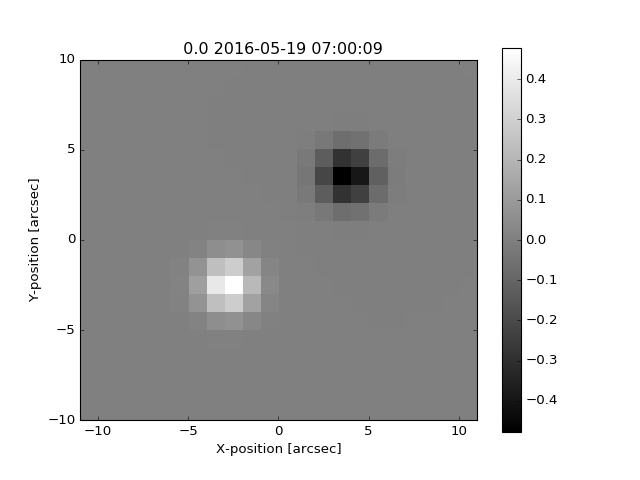

In [75]:
map_boundary.peek()

## Field Extrapolation
Now, from this simulated magnetogram, we want to perform a magnetic field extrapolation using the potential field source surface (`pfss`) routine. First, define the extrapolator instance.

In [76]:
aPotExt = PotentialExtrapolator(map_boundary,zshape=arr_grid_shape[2],zrange=zrange)

/Users/willbarnes/anaconda/envs/python2/lib/python2.7/site-packages/sunpy/map/mapbase.pyc:133: Warning: Missing metadata for Sun-spacecraft separation: assuming Sun-Earth distance
  The `~astropy.wcs.WCS` property of the map.


In [77]:
aMap3D  = aPotExt.extrapolate(enable_numba=True)

False


There is some metadata attached here too. Let's have a look.

In [78]:
aMap3D.meta

{'boundary_1_meta': MapMeta([('rsun_ref', 696000000),
          ('naxis', 2),
          ('naxis2', 20),
          ('crval2', 0.0),
          ('crpix1', 11.5),
          ('t_obs', '2016-05-19T02:00:08.009210'),
          ('crpix2', 10.5),
          ('naxis1', 8),
          ('cdelt1', 1.0),
          ('cdelt2', 1.0),
          ('crval1', 0.0),
          ('datavals', 400),
          ('dsun_ref', 149597870691),
          ('cunit1', 'arcsec'),
          ('bunit', 'Tesla'),
          ('bitpix', 64),
          ('cunit2', 'arcsec'),
          ('datamin', -0.47799874091654987),
          ('datamax', 0.47799874091654987)]),
 'cdelt1': 1.1,
 'cdelt2': 0.9090909090909091,
 'cdelt3': 1.0,
 'cunit1': Unit("arcsec"),
 'cunit2': Unit("arcsec"),
 'cunit3': Unit("arcsec"),
 'extrapolator_duration': 0.5577189922332764,
 'extrapolator_duration_unit': Unit("s"),
 'extrapolator_notes': '',
 'extrapolator_routine': 'Potential Field Extrapolator',
 'extrapolator_start_time': '2016-05-19T02:00:12.640906',
 'na

So now in `aMap3D` we have a 3D vector field,  4D object, such that there is a dimension for each cartesian coordinate of the magnetic field, $B_x,B_y,B_z$. The other dimensions are consistent with those we specified with our cuboid, as they should be.

So now that we have our extrapolated 3D vector field, what do we do with it? Can we plot it with matplotlib?

<IPython.core.display.Javascript object>


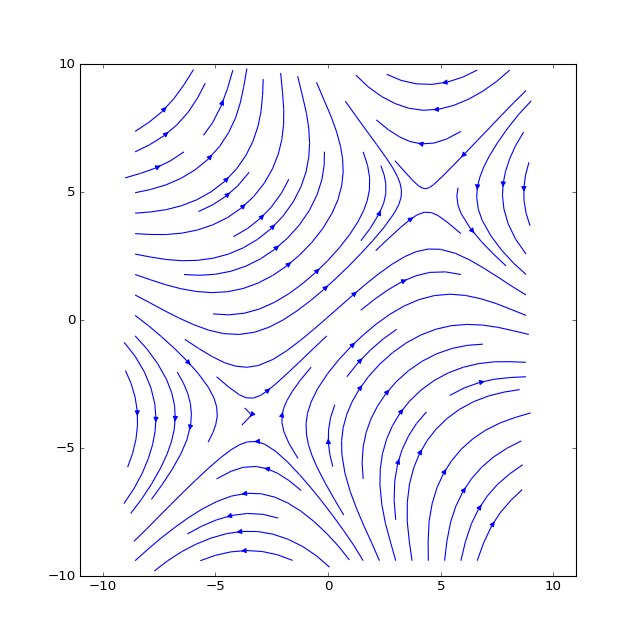

(-10, 10)

In [79]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.streamplot(np.linspace(xrange.value[0],xrange.value[1],arr_grid_shape[1]),
              np.linspace(yrange.value[0],yrange.value[1],arr_grid_shape[0]),
              aMap3D.data[:,:,5,0],aMap3D.data[:,:,5,1])
ax.set_xlim([-11,11])
ax.set_ylim([-10,10])

## Analysis with `yt`
We first need to reshape our data to "play nice" with `yt`. See [here](http://yt-project.org/doc/examining/generic_array_data.html#loading-numpy-array) for more info. 

In [83]:
data = dict(
    Bx=(aMap3D.data[:,:,:,0],"T"),
    By=(aMap3D.data[:,:,:,1],"T"),
    Bz=(aMap3D.data[:,:,:,2],"T")
)

In [84]:
bbox = np.array([yrange.value,xrange.value,zrange.value])

In [85]:
ds = yt.load_uniform_grid(data,data['Bx'][0].shape,
                          length_unit="arcsec",bbox=bbox)

yt : [INFO     ] 2016-05-19 02:00:36,822 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-05-19 02:00:36,823 Parameters: domain_dimensions         = [20 22 20]
yt : [INFO     ] 2016-05-19 02:00:36,826 Parameters: domain_left_edge          = [-11. -10.   0.]
yt : [INFO     ] 2016-05-19 02:00:36,828 Parameters: domain_right_edge         = [ 11.  10.  20.]
yt : [INFO     ] 2016-05-19 02:00:36,832 Parameters: cosmological_simulation   = 0.0


Now set up the streamline calculation. The main question is how to calculate the seedpoints? Try using the `yt` example first.

In [103]:
c = ds.domain_left_edge + np.array([0.35*ds.domain_width[0],0.35*ds.domain_width[1],0])*ds.domain_width[0]/ds.domain_width[0].value
N = 100
pos_dx = np.random.normal(scale=ds.domain_width[0].value/15./expand,size=(N,3))*ds.domain_width[0]/ds.domain_width.value
pos = c+pos_dx
for p in pos:
    p[-1] = 1.1

Calculate the streamlines!

In [104]:
streamlines = Streamlines(ds, pos, 'Bx', 'By', 'Bz',get_magnitude=True,direction=1)
streamlines.integrate_through_volume()

yt : [INFO     ] 2016-05-19 02:05:39,662 AMRKDTree rebuilt, Final Volume: 8.800000e+03


<IPython.core.display.Javascript object>


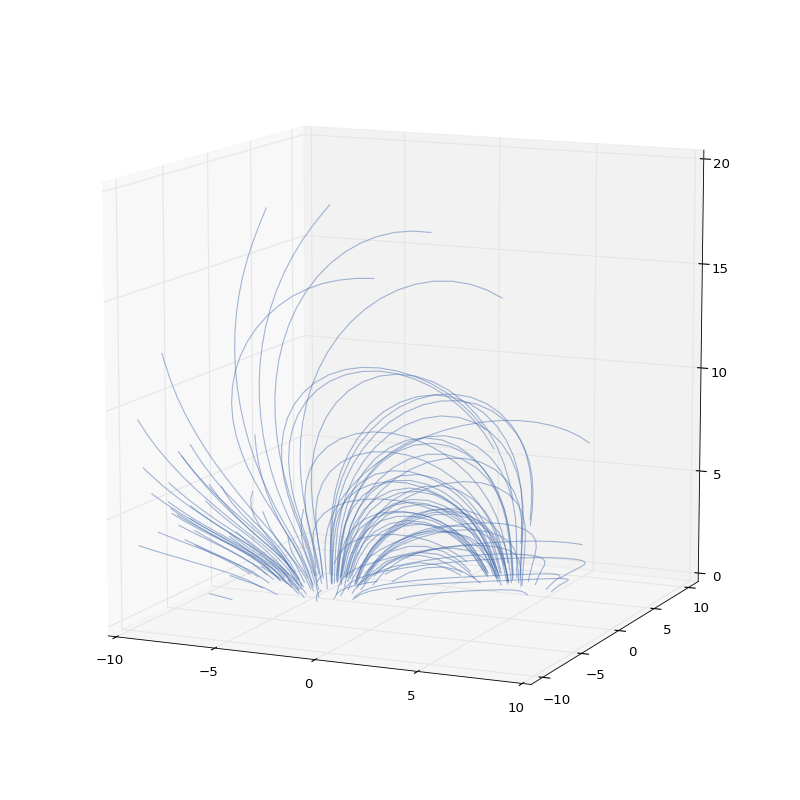

(0, 20)

In [105]:
fig=plt.figure(figsize=(10,10))
ax = Axes3D(fig)
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    ax.plot3D(stream[:,0], stream[:,1], stream[:,2], alpha=0.5,color=sns.color_palette('deep')[0])
ax.set_xlim([-10,10])
ax.set_ylim([-11,11])
ax.set_zlim([0,20])

In [43]:
test_stream = streamlines.path(0)

In [53]:
loop_lengths = []
for i in range(N):
    loop_length = 0
    r = streamlines.path(i).positions
    for i in range(len(r)-1):
        loop_length += np.linalg.norm(r[i+1]-r[i])
    loop_lengths.append(loop_length)

<IPython.core.display.Javascript object>


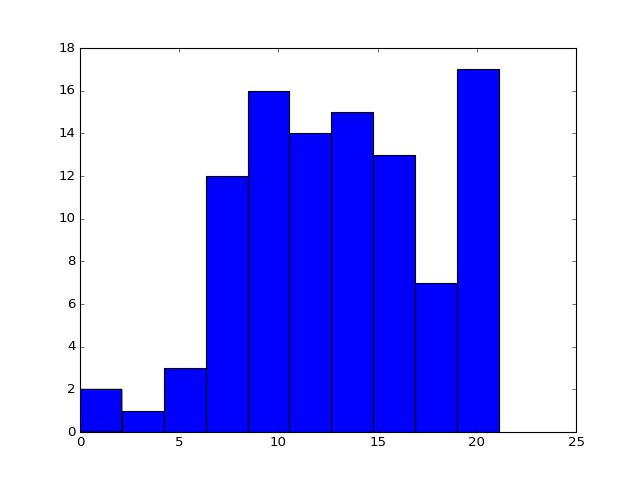

(array([  2.,   1.,   3.,  12.,  16.,  14.,  15.,  13.,   7.,  17.]),
 array([  0.        ,   2.11097515,   4.2219503 ,   6.33292546,
          8.44390061,  10.55487576,  12.66585091,  14.77682606,
         16.88780121,  18.99877637,  21.10975152]),
 <a list of 10 Patch objects>)

In [93]:
fig = plt.figure()
ax = fig.gca()
ax.hist(loop_lengths)